<a href="https://colab.research.google.com/github/akritilosalka12/Project-Based-Learning-on-Detection-of-Suicidal-Ideation-using-Natural-Language-Processing/blob/main/Suicide_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer



In [ ]:
# Load dataset
df = pd.read_csv("/content/500 data2.csv")


In [ ]:
# prompt: write the code to show the dataset upto 100 lines

print(df.head(100))


                                                Tweet        Label
0   Ex Wife Threatening SuicideRecently I left my ...      suicide
1   Am I weird I don't get affected by compliments...  non-suicide
2   Finally 2020 is almost over... So I can never ...  non-suicide
3           i need helpjust help me im crying so hard      suicide
4   I’m so lostHello, my name is Adam (16) and I’v...      suicide
..                                                ...          ...
95  day 3 of posting something i get mildly infuri...  non-suicide
96  A lot of stuff to handle at once for me \nSorr...  non-suicide
97  I'm going to wait for a version of senorita In...  non-suicide
98  You know I just realized you cant have an opin...  non-suicide
99  2929\n\n\nThat’s the oldest I’ve ever been. It...      suicide

[100 rows x 2 columns]


In [ ]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors="pt")

# Assuming 'Tweet' is the name of the column containing the text data
df['tokens'] = df['Tweet'].apply(lambda x: tokenize_text(x))

In [ ]:
print(df.columns)


Index(['Tweet', 'Label', 'tokens'], dtype='object')


In [ ]:
# Handling Class Imbalance
X = df['tokens'].tolist()
y = df['Label'].values  # Corrected column name



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Extract input_ids and convert to 2D array
X = np.array([token['input_ids'].squeeze().numpy() for token in df['tokens']], dtype=np.int64)

# Encode labels to integers if they are not already
le = LabelEncoder()
y = le.fit_transform(df['Label'])

# Apply SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert to tensors
X_resampled_tensor = torch.tensor(X_resampled, dtype=torch.long)
y_resampled_tensor = torch.tensor(y_resampled, dtype=torch.long)


In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled_tensor, y_resampled_tensor, test_size=0.2, random_state=42)

In [ ]:
# Define BiLSTM + BERT Model
class SuicideDetectionModel(nn.Module):
    def __init__(self):
        super(SuicideDetectionModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids):
        with torch.no_grad():
            bert_output = self.bert(input_ids)[0]
        lstm_output, _ = self.lstm(bert_output)
        output = self.fc(lstm_output[:, -1, :])
        return self.sigmoid(output)

In [ ]:
# Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SuicideDetectionModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

for epoch in range(5):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train.to(device)).squeeze()
    loss = criterion(predictions, y_train.float().to(device))
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1, Loss: 0.6920948624610901
Epoch 2, Loss: 0.6914205551147461
Epoch 3, Loss: 0.6903480887413025
Epoch 4, Loss: 0.6892428994178772
Epoch 5, Loss: 0.6883607506752014


In [ ]:
# Evaluate
model.eval()
with torch.no_grad():
    predictions = model(X_test.to(device)).squeeze()
    accuracy = ((predictions.round() == y_test.to(device)).sum().item()) / len(y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 58.97%



Classification Report:

              precision    recall  f1-score   support

 non-suicide       0.54      0.97      0.70        38
     suicide       0.90      0.23      0.36        40

    accuracy                           0.59        78
   macro avg       0.72      0.60      0.53        78
weighted avg       0.73      0.59      0.52        78



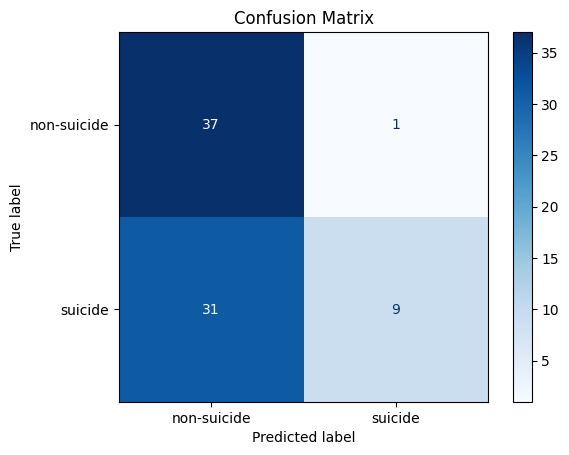

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert predictions to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).long().cpu().numpy()
true_labels = y_test.cpu().numpy()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


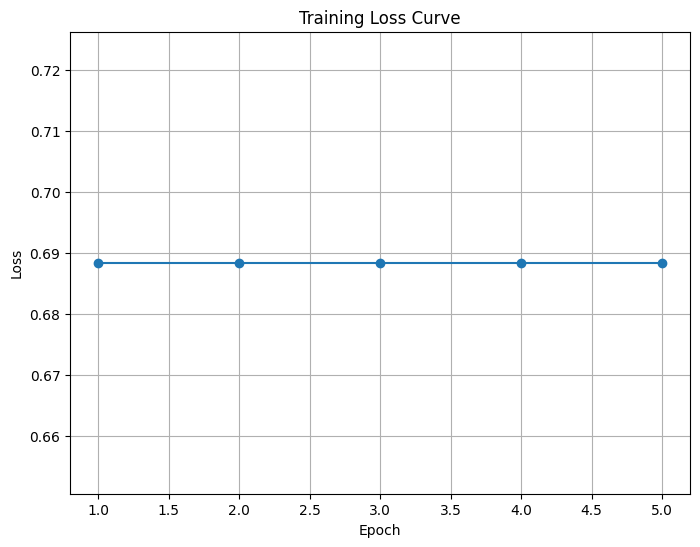

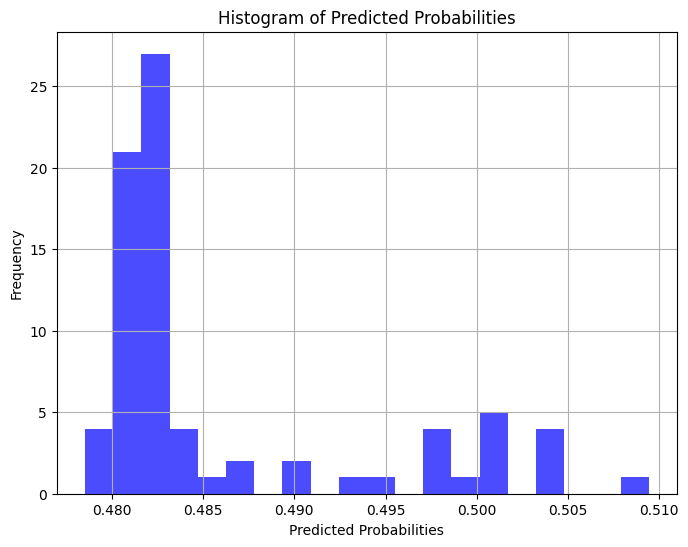

In [ ]:
# prompt: plot graphs using matplotlib

# ... (Your existing code)

# Assuming 'predictions' and 'y_test' are available after model evaluation

# Plot the loss curve (example)
# Assuming you have a list or array called 'losses' containing the loss values from each epoch
# Replace this with your actual loss values
losses = [loss.item() for epoch in range(5)]  # Placeholder - replace with your actual loss values

plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# Plot a histogram of predictions
plt.figure(figsize=(8, 6))
plt.hist(predictions.cpu().numpy(), bins=20, alpha=0.7, color='blue')  # Assuming predictions is a tensor; use .cpu().numpy() to get numpy array
plt.xlabel("Predicted Probabilities")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Probabilities")
plt.grid(True)
plt.show()
